# Data Mining
## Semester Project
### Supervisors: Dr. Sibt-ul-Hussain and Atique-ur-Rehman
#### By: Zeeshan Ali, i14-1623, A
###### Cleaning of Train Data -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
%pylab inline
import scipy.stats
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import os


plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
print "Matplotlib version : ", matplotlib.__version__
print "Pandas version : ", pd.__version__
print "Numpy version : ", np.__version__
print "Scipy version : ", scipy.__version__
print "Seaborn version : ", sns.__version__
print "Sklearn version : ", sk.__version__
print "Tensorflow version : ", tf.__version__

Matplotlib version :  2.0.0
Pandas version :  0.19.2
Numpy version :  1.11.3
Scipy version :  0.18.1
Seaborn version :  0.7.1
Sklearn version :  0.18.1
Tensorflow version :  1.1.0


# Region Information Table
It shows the information about the regions to be evaluated in the contest.  You need to do the prediction given the regions from the Region Definition Table.  In the submission of the results, you need to map the region hash value to region mapped ID.

In [3]:
cluster_map_dir = './training_data/cluster_map/'
cluster_map_files = [f for f in os.listdir(cluster_map_dir) if not f.startswith('.')]
print 'Number of cluster_map files =', len(cluster_map_files)
cluster_map_data = []
for File in cluster_map_files:
    cluster_map_data.append(pd.read_table(cluster_map_dir+File, error_bad_lines=False, index_col=None, header=-1))
cluster_map_data = pd.concat(cluster_map_data, ignore_index=True)
cluster_map_data.columns = ['region_hash', 'region_id']
cluster_map_data.tail()

Number of cluster_map files = 1


,region_hash,region_id
61,a735449c5c09df639c35a7d61fad3ee5,62
62,0a5fef95db34383403d11cb6af937309,63
63,bf44d327f0232325c6d5280926d7b37d,64
64,825a21aa308dea206adb49c4b77c7805,65
65,1ecbb52d73c522f184a6fc53128b1ea1,66


# Order Information Table
It  shows  the  basic  information  of  an  order,  including  the  passenger  and  the  driver  (if driver id =NULL, it means the order was not answered by any driver), place of origin, destination, price and time.  The fields order id, driver id, passenger id, start hash, and dest hash are made not sensitive.

In [4]:
order_data_dir = './training_data/order_data/'
order_data_files = [f for f in os.listdir(order_data_dir) if not f.startswith('.')]
print 'Number of order_data files =', len(order_data_files)
order_data = []
for File in order_data_files:
    order_data.append(pd.read_table(order_data_dir+File, error_bad_lines=False, index_col=None, header=-1))
order_data = pd.concat(order_data, ignore_index=True)
order_data.columns = ['order_id', 'driver_id', 'passenger_id', 'start_region_hash', 'dest_region_hash', 'Price', 'Time']
order_data.tail()

Number of order_data files = 21


,order_id,driver_id,passenger_id,start_region_hash,dest_region_hash,Price,Time
8540609,34d169b2a5e7ee5747b542263301d6a8,2f98ab84031fe8a108c8fed1e46d165e,d493f9cafa2aee4e02baa9c3f217528a,d4ec2125aff74eded207d2d915ef682f,d4ec2125aff74eded207d2d915ef682f,17.0,2016-01-09 01:59:49
8540610,b1082907027935c1cb0aab60088d7040,a71d03658f9ffd5c613a472832863fb9,be9bbe6200f9c7bd788516a74dc5229d,ca064c2682ca48c6a21de012e87c0df5,ca064c2682ca48c6a21de012e87c0df5,8.0,2016-01-09 07:03:39
8540611,fab05cf1c37d7ef03f74c4fbc27ed6f9,1b9f88c2d50c6c67a9ba62017885aee9,68b1e7223567034336b8c2cdca5d49fe,929ec6c160e6f52c20a4217c7978f681,b05379ac3f9b7d99370d443cfd5dcc28,18.0,2016-01-09 08:36:59
8540612,e67628ffd2203bd07d50d2a0ab262810,160320d352563b69243641d5ae025347,03a59fedabb3fe9cfb5942be94f49a37,bf44d327f0232325c6d5280926d7b37d,bf44d327f0232325c6d5280926d7b37d,8.0,2016-01-09 17:58:53
8540613,693191ec3a283336117d58448584e12d,462c7bab621c7b252a3281804638c1fc,087bfc235ff8a7611120a91dcf987df2,d4ec2125aff74eded207d2d915ef682f,82cc4851f9e4faa4e54309f8bb73fd7c,22.0,2016-01-09 20:11:08


In [5]:
print len(order_data.start_region_hash.unique()), len(order_data.dest_region_hash.unique())

66 793


# POI Information Table
The  POI  Information  Table  shows  the  attributes  of  a  region,  such  as  the  number  of  different  facilities.

**For example:**

2#1:22 means in this region, there are 22 facilities of the facility class 2#1.

2#1 means the first level class is 2 and the second level is 1, such as entertainment#theater, shopping#home appliance, sports#others.

Each class and its number is separated by a colon ':'

In [6]:
poi_data_dir = './training_data/poi_data/'
poi_data_files = [f for f in os.listdir(poi_data_dir) if not f.startswith('.')]
print 'Number of poi_data files =', len(poi_data_files)
poi_data = []
columns = ['region_hash']
columns += [str(i+1) for i in range(152)]
for File in poi_data_files:
    poi_data.append(pd.read_table(poi_data_dir+File, error_bad_lines=False, index_col=None, header=-1, names=columns))
poi_data = pd.concat(poi_data, ignore_index=True)
poi_data.tail()

Number of poi_data files = 1


,region_hash,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
61,d4ec2125aff74eded207d2d915ef682f,4#16:1577,1#10:332,24:3486,25:15272,20:197125,22:1162,23:13612,4:44903,8:3818,...,2#4:581,2#5:2988,2#6:12699,2#7:2656,2#1:581,2#2:21746,2#3:1577,21#1:83,13#2:83,NaN
62,82cc4851f9e4faa4e54309f8bb73fd7c,4#16:498,1#10:830,24:6308,25:4897,20:56440,22:2739,23:4980,4:22576,8:996,...,2#3:664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,fff4e8465d1e12621bc361276b6217cf,20#7:1494,20#5:249,20#4:1660,8#4:747,20#1:1494,16#12:332,16#10:581,20#8:3818,23#3:83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,b05379ac3f9b7d99370d443cfd5dcc28,4#16:166,1#10:332,24:1411,25:1826,20:37433,22:2324,23:2241,4:9628,5#4:83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,fc34648599753c9e74ab238e9a4a07ad,4#16:498,1#10:166,24:996,25:1411,20:32951,22:1079,23:747,4:7636,8:332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Weather Information Table
The Weather Information Table shows the weather info every 10 minutes each city.  The weather field gives the weather
conditions such as sunny, rainy, and snowy etc; all sensitive information has been removed.  The unit of temperature is
Celsius degree, and PM2_5 is the level of air pollutions.

In [7]:
weather_data_dir = './training_data/weather_data/'
weather_data_files = [f for f in os.listdir(weather_data_dir) if not f.startswith('.')]
print 'Number of weather_data files =', len(weather_data_files)
weather_data = []
for File in weather_data_files:
    weather_data.append(pd.read_table(weather_data_dir+File, error_bad_lines=False, index_col=None, header=-1))
weather_data = pd.concat(weather_data, ignore_index=True)
weather_data.columns = ['Time', 'Weather', 'temperature', 'PM2_5']
weather_data.tail()

Number of weather_data files = 21


,Time,Weather,temperature,PM2_5
4806,2016-01-21 23:35:24,2,1.0,58
4807,2016-01-21 23:40:46,2,1.0,59
4808,2016-01-21 23:45:44,2,1.0,59
4809,2016-01-21 23:50:31,2,1.0,59
4810,2016-01-21 23:55:26,2,1.0,59


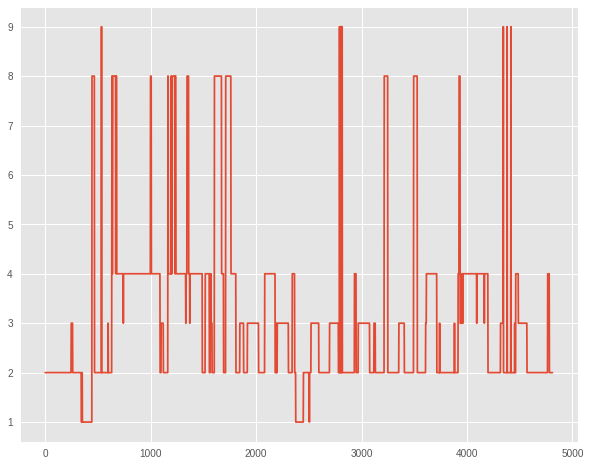

In [8]:
plt.plot(weather_data.Weather)

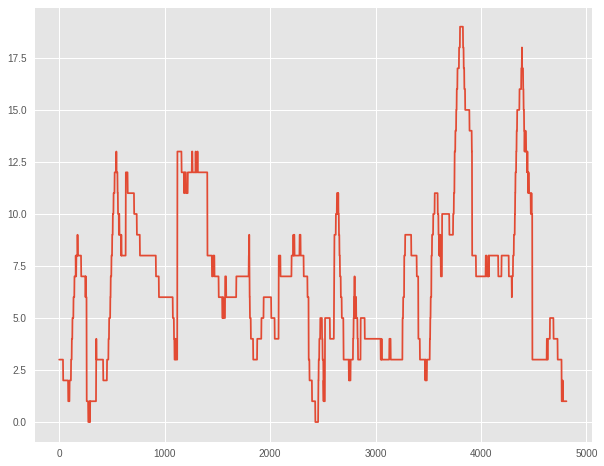

In [9]:
plt.plot(weather_data.temperature)

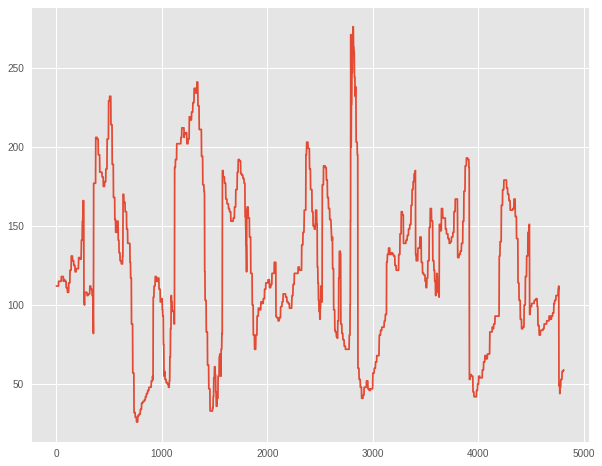

In [10]:
plt.plot(weather_data.PM2_5)

# Region-Group-Facilities Information Table

In [11]:
poi_cols = []
for r in poi_data:
    poi_cols.append(r)
poi_cols = poi_cols[1:]

facilities = []
for p in range(len(poi_data)):
    for col in poi_cols:
        string = poi_data[col][p]
        if type(string)==type('str'):
            new_row = ['', '', '']
            new_row[0] = poi_data['region_hash'][p]
            new_row[1] = string[:string.index(':')]
            new_row[2] = string[string.index(':')+1:]
            facilities.append(new_row)
        
facilities = pd.DataFrame(facilities, columns=['region_hash', 'Group', 'Facilities'])
facilities.tail()

,region_hash,Group,Facilities
6581,fc34648599753c9e74ab238e9a4a07ad,2#7,1079
6582,fc34648599753c9e74ab238e9a4a07ad,2#1,498
6583,fc34648599753c9e74ab238e9a4a07ad,2#2,4731
6584,fc34648599753c9e74ab238e9a4a07ad,21#2,83
6585,fc34648599753c9e74ab238e9a4a07ad,21#1,83


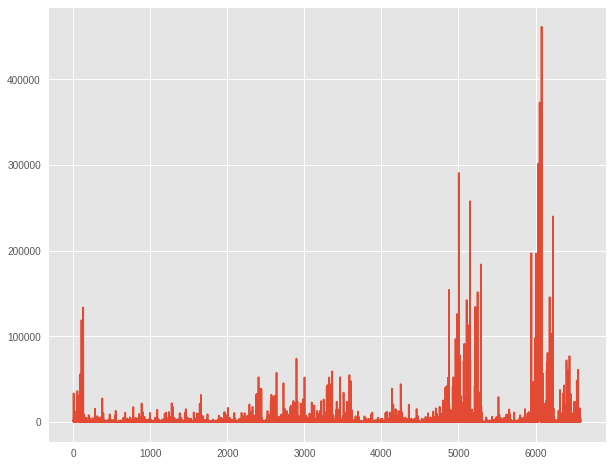

In [12]:
plt.plot(facilities.Facilities)

# Region-Weighted_Mean_Facilities Information Table

In [13]:
# weights of each class, say 1#2.
weight = defaultdict()
for g in facilities.Group:
    if g not in weight:
        weight[g] = 0
    else:
        weight[g] += 1
weight

defaultdict(None,
            {'1': 55,
             '1#1': 30,
             '1#10': 27,
             '1#11': 56,
             '1#2': 53,
             '1#3': 36,
             '1#4': 36,
             '1#5': 60,
             '1#6': 36,
             '1#7': 19,
             '1#8': 55,
             '1#9': 25,
             '10#1': 0,
             '11': 62,
             '11#1': 45,
             '11#2': 51,
             '11#3': 47,
             '11#4': 61,
             '11#5': 39,
             '11#6': 61,
             '11#7': 54,
             '11#8': 63,
             '12': 3,
             '13#1': 0,
             '13#2': 0,
             '13#3': 0,
             '13#4': 65,
             '13#5': 29,
             '13#6': 33,
             '13#7': 0,
             '13#8': 35,
             '14': 43,
             '14#1': 1,
             '14#10': 36,
             '14#2': 27,
             '14#3': 46,
             '14#4': 1,
             '14#5': 0,
             '14#6': 51,
             '14#7': 26,
        

In [14]:
weighted_sum = {}
Sum = np.sum(weight.values())    # sum of all the weights in 'weight' dictionary
for r in range(len(poi_data)):
    weighted_sum[poi_data.region_hash[r]] = 0
    for col in poi_cols:
        string = poi_data[col][r]
        if type(string) == type('str'):
            w = weight[string[:string.index(':')]]
            weighted_sum[poi_data.region_hash[r]] += w * int(string[string.index(':')+1:])
    weighted_sum[poi_data.region_hash[r]] /= Sum
weighted_sum = pd.DataFrame(weighted_sum.items(), columns=['region_hash', 'Facilities'])
weighted_sum.tail()

,region_hash,Facilities
61,1cbfbdd079ef93e74405c53fcfff8567,977
62,4b9e4cf2fbdc8281b8a1f9f12b80ce4d,253
63,82cc4851f9e4faa4e54309f8bb73fd7c,14166
64,4b7f6f4e2bf237b6cc58f57142bea5c0,987
65,2350be163432e42270d2670cb3c02f80,1209


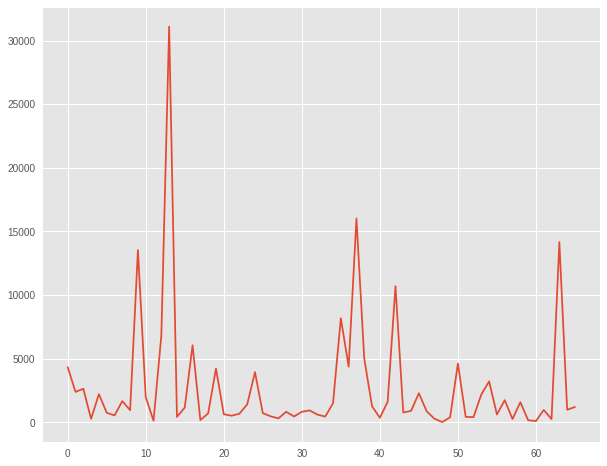

In [15]:
plt.plot(weighted_sum.Facilities)

# Supply-Demand Information Table

In [50]:
Supply_Demand_data = order_data[['driver_id', 'start_region_hash', 'Time']]
Supply_Demand_data.tail()

,driver_id,start_region_hash,Time
8540609,2f98ab84031fe8a108c8fed1e46d165e,d4ec2125aff74eded207d2d915ef682f,2016-01-09 01:59:49
8540610,a71d03658f9ffd5c613a472832863fb9,ca064c2682ca48c6a21de012e87c0df5,2016-01-09 07:03:39
8540611,1b9f88c2d50c6c67a9ba62017885aee9,929ec6c160e6f52c20a4217c7978f681,2016-01-09 08:36:59
8540612,160320d352563b69243641d5ae025347,bf44d327f0232325c6d5280926d7b37d,2016-01-09 17:58:53
8540613,462c7bab621c7b252a3281804638c1fc,d4ec2125aff74eded207d2d915ef682f,2016-01-09 20:11:08


In [51]:
print len(Supply_Demand_data['Time'].unique()), len(weather_data['Time'].unique())

1534340 4811


In [52]:
Supply_Demand_data = pd.merge(Supply_Demand_data, weather_data, how='left')
Supply_Demand_data.head()

,driver_id,start_region_hash,Time,Weather,temperature,PM2_5
0,6f7b41c8e3ce01acd520ffd275ed8f91,2407d482f0ffa22a947068f2551fe62c,2016-01-21 09:28:04,NaN,NaN,NaN
1,f28b6ba781cc01b6570ccf8d535092e2,d4ec2125aff74eded207d2d915ef682f,2016-01-21 16:05:21,NaN,NaN,NaN
2,7ba52ec2fea09144e3ae8327ff2ebf65,929ec6c160e6f52c20a4217c7978f681,2016-01-21 13:59:00,NaN,NaN,NaN
3,07b57eede4fb96c33a3e37635ca1e67e,d4ec2125aff74eded207d2d915ef682f,2016-01-21 18:26:58,NaN,NaN,NaN
4,36cc5524fb00191b47e69280f0556c38,ca064c2682ca48c6a21de012e87c0df5,2016-01-21 15:54:33,NaN,NaN,NaN


In [53]:
Supply_Demand_data.tail()

,driver_id,start_region_hash,Time,Weather,temperature,PM2_5
8540609,2f98ab84031fe8a108c8fed1e46d165e,d4ec2125aff74eded207d2d915ef682f,2016-01-09 01:59:49,NaN,NaN,NaN
8540610,a71d03658f9ffd5c613a472832863fb9,ca064c2682ca48c6a21de012e87c0df5,2016-01-09 07:03:39,NaN,NaN,NaN
8540611,1b9f88c2d50c6c67a9ba62017885aee9,929ec6c160e6f52c20a4217c7978f681,2016-01-09 08:36:59,NaN,NaN,NaN
8540612,160320d352563b69243641d5ae025347,bf44d327f0232325c6d5280926d7b37d,2016-01-09 17:58:53,NaN,NaN,NaN
8540613,462c7bab621c7b252a3281804638c1fc,d4ec2125aff74eded207d2d915ef682f,2016-01-09 20:11:08,NaN,NaN,NaN


In [54]:
day = []
month = []
time_slot = []
for t in Supply_Demand_data['Time']:
    day.append(t[8:10])
    month.append(t[5:7])
    time_slot.append((int(t[11:13])*60*60+int(t[14:16])*60+int(t[17:19]))//600)

Supply_Demand_data = Supply_Demand_data.assign(Day = day)
Supply_Demand_data = Supply_Demand_data.assign(Month = month)
Supply_Demand_data = Supply_Demand_data.assign(Time_slot = time_slot)
Supply_Demand_data.tail()

,driver_id,start_region_hash,Time,Weather,temperature,PM2_5,Day,Month,Time_slot
8540609,2f98ab84031fe8a108c8fed1e46d165e,d4ec2125aff74eded207d2d915ef682f,2016-01-09 01:59:49,NaN,NaN,NaN,09,01,11
8540610,a71d03658f9ffd5c613a472832863fb9,ca064c2682ca48c6a21de012e87c0df5,2016-01-09 07:03:39,NaN,NaN,NaN,09,01,42
8540611,1b9f88c2d50c6c67a9ba62017885aee9,929ec6c160e6f52c20a4217c7978f681,2016-01-09 08:36:59,NaN,NaN,NaN,09,01,51
8540612,160320d352563b69243641d5ae025347,bf44d327f0232325c6d5280926d7b37d,2016-01-09 17:58:53,NaN,NaN,NaN,09,01,107
8540613,462c7bab621c7b252a3281804638c1fc,d4ec2125aff74eded207d2d915ef682f,2016-01-09 20:11:08,NaN,NaN,NaN,09,01,121


In [55]:
Supply_Demand_data=Supply_Demand_data.merge(weighted_sum, left_on='start_region_hash', right_on='region_hash', how='left')
Supply_Demand_data.tail()

,driver_id,start_region_hash,Time,Weather,temperature,PM2_5,Day,Month,Time_slot,region_hash,Facilities
8540609,2f98ab84031fe8a108c8fed1e46d165e,d4ec2125aff74eded207d2d915ef682f,2016-01-09 01:59:49,NaN,NaN,NaN,09,01,11,d4ec2125aff74eded207d2d915ef682f,31088
8540610,a71d03658f9ffd5c613a472832863fb9,ca064c2682ca48c6a21de012e87c0df5,2016-01-09 07:03:39,NaN,NaN,NaN,09,01,42,ca064c2682ca48c6a21de012e87c0df5,4227
8540611,1b9f88c2d50c6c67a9ba62017885aee9,929ec6c160e6f52c20a4217c7978f681,2016-01-09 08:36:59,NaN,NaN,NaN,09,01,51,929ec6c160e6f52c20a4217c7978f681,10702
8540612,160320d352563b69243641d5ae025347,bf44d327f0232325c6d5280926d7b37d,2016-01-09 17:58:53,NaN,NaN,NaN,09,01,107,bf44d327f0232325c6d5280926d7b37d,1986
8540613,462c7bab621c7b252a3281804638c1fc,d4ec2125aff74eded207d2d915ef682f,2016-01-09 20:11:08,NaN,NaN,NaN,09,01,121,d4ec2125aff74eded207d2d915ef682f,31088


In [56]:
Supply_Demand_data = pd.merge(Supply_Demand_data, cluster_map_data, how='left')
Supply_Demand_data.tail()

,driver_id,start_region_hash,Time,Weather,temperature,PM2_5,Day,Month,Time_slot,region_hash,Facilities,region_id
8540609,2f98ab84031fe8a108c8fed1e46d165e,d4ec2125aff74eded207d2d915ef682f,2016-01-09 01:59:49,NaN,NaN,NaN,09,01,11,d4ec2125aff74eded207d2d915ef682f,31088,51
8540610,a71d03658f9ffd5c613a472832863fb9,ca064c2682ca48c6a21de012e87c0df5,2016-01-09 07:03:39,NaN,NaN,NaN,09,01,42,ca064c2682ca48c6a21de012e87c0df5,4227,42
8540611,1b9f88c2d50c6c67a9ba62017885aee9,929ec6c160e6f52c20a4217c7978f681,2016-01-09 08:36:59,NaN,NaN,NaN,09,01,51,929ec6c160e6f52c20a4217c7978f681,10702,7
8540612,160320d352563b69243641d5ae025347,bf44d327f0232325c6d5280926d7b37d,2016-01-09 17:58:53,NaN,NaN,NaN,09,01,107,bf44d327f0232325c6d5280926d7b37d,1986,64
8540613,462c7bab621c7b252a3281804638c1fc,d4ec2125aff74eded207d2d915ef682f,2016-01-09 20:11:08,NaN,NaN,NaN,09,01,121,d4ec2125aff74eded207d2d915ef682f,31088,51


In [57]:
# delete the 'region_hash' column because it is the same as 'start_region_hash'
del Supply_Demand_data['region_hash']
Supply_Demand_data.tail()

,driver_id,start_region_hash,Time,Weather,temperature,PM2_5,Day,Month,Time_slot,Facilities,region_id
8540609,2f98ab84031fe8a108c8fed1e46d165e,d4ec2125aff74eded207d2d915ef682f,2016-01-09 01:59:49,NaN,NaN,NaN,09,01,11,31088,51
8540610,a71d03658f9ffd5c613a472832863fb9,ca064c2682ca48c6a21de012e87c0df5,2016-01-09 07:03:39,NaN,NaN,NaN,09,01,42,4227,42
8540611,1b9f88c2d50c6c67a9ba62017885aee9,929ec6c160e6f52c20a4217c7978f681,2016-01-09 08:36:59,NaN,NaN,NaN,09,01,51,10702,7
8540612,160320d352563b69243641d5ae025347,bf44d327f0232325c6d5280926d7b37d,2016-01-09 17:58:53,NaN,NaN,NaN,09,01,107,1986,64
8540613,462c7bab621c7b252a3281804638c1fc,d4ec2125aff74eded207d2d915ef682f,2016-01-09 20:11:08,NaN,NaN,NaN,09,01,121,31088,51


In [58]:
date = []
for ind in range(Supply_Demand_data.shape[0]):
    date.append(Supply_Demand_data['Time'][ind][:10])

del Supply_Demand_data['Time']
Supply_Demand_data = Supply_Demand_data.assign(Date = date)
Supply_Demand_data.tail()

,driver_id,start_region_hash,Weather,temperature,PM2_5,Day,Month,Time_slot,Facilities,region_id,Date
8540609,2f98ab84031fe8a108c8fed1e46d165e,d4ec2125aff74eded207d2d915ef682f,NaN,NaN,NaN,09,01,11,31088,51,2016-01-09
8540610,a71d03658f9ffd5c613a472832863fb9,ca064c2682ca48c6a21de012e87c0df5,NaN,NaN,NaN,09,01,42,4227,42,2016-01-09
8540611,1b9f88c2d50c6c67a9ba62017885aee9,929ec6c160e6f52c20a4217c7978f681,NaN,NaN,NaN,09,01,51,10702,7,2016-01-09
8540612,160320d352563b69243641d5ae025347,bf44d327f0232325c6d5280926d7b37d,NaN,NaN,NaN,09,01,107,1986,64,2016-01-09
8540613,462c7bab621c7b252a3281804638c1fc,d4ec2125aff74eded207d2d915ef682f,NaN,NaN,NaN,09,01,121,31088,51,2016-01-09


# Handling NaN-Values

In [63]:
# Returns the most recurring non-zero number in the array
def mode(A):
    Dict = {}
    A = np.array(A)
    for a in np.unique(A):
        Dict[str(a)] = (a!=0) * (A[A==a].shape[0])
    return max(Dict.iterkeys(), key=lambda k: Dict[k])

In [64]:
mode([3.14, 2.76, 1.4, 2.0, 3.14, 0, 0, 0, 0, 0, 0, 0, 0])

'3.14'

In [65]:
# Replace all the 'NaN' values in columns ['Weather', 'tempreture', 'PM2_5'] by value=0
Supply_Demand_data['Weather'] = Supply_Demand_data['Weather'].fillna(value=0)
Supply_Demand_data['temperature'] = Supply_Demand_data['temperature'].fillna(value=0)
Supply_Demand_data['PM2_5'] = Supply_Demand_data['PM2_5'].fillna(value=0)

In [66]:
# Declare dictionaries to store avg values of the columns for each time slot
mode_Weather = {}
mode_temperature = {}
mode_PM = {}

# Set initial avg values to an empty array
for date in Supply_Demand_data.Date.unique():
    for slot in Supply_Demand_data.Time_slot.unique():
        mode_Weather[date + str(slot)] = []
        mode_temperature[date + str(slot)] = []
        mode_PM[date + str(slot)] = []

In [67]:
# Append the values at the time slot of each column respectively to their containers
for order in range(len(Supply_Demand_data)):
    key = Supply_Demand_data['Date'][order] + str(Supply_Demand_data['Time_slot'][order])
    mode_Weather[key].append(Supply_Demand_data['Weather'][order])
    mode_temperature[key].append(Supply_Demand_data['temperature'][order])
    mode_PM[key].append(Supply_Demand_data['PM2_5'][order])

# Replace the containers with the most recurring value in them respectively
for date in Supply_Demand_data.Date.unique():
    for slot in Supply_Demand_data.Time_slot.unique():
        mode_Weather[date + str(slot)] = int(float(mode(mode_Weather[date + str(slot)])))
        mode_temperature[date + str(slot)] = float(mode(mode_temperature[date + str(slot)]))
        mode_PM[date + str(slot)] = int(float(mode(mode_PM[date + str(slot)])))

In [68]:
wther = []
tempr = []
pm2_5 = []
# Replace each zeros with the most-likey values in the respective slot
for order in range(Supply_Demand_data.shape[0]):
    key = Supply_Demand_data['Date'][order] + str(Supply_Demand_data['Time_slot'][order])
    if Supply_Demand_data['Weather'][order] == 0:
        wther.append(mode_Weather[key])
    else:
        wther.append(Supply_Demand_data['Weather'][order])
    if Supply_Demand_data['temperature'][order] == 0:
        tempr.append(mode_temperature[key])
    else:
        tempr.append(Supply_Demand_data['temperature'][order])
    if Supply_Demand_data['PM2_5'][order] == 0:
        pm2_5.append(mode_Weather[key])
    else:
        pm2_5.append(Supply_Demand_data['PM2_5'][order])
        
Supply_Demand_data = Supply_Demand_data.assign(Weather = wther)
Supply_Demand_data = Supply_Demand_data.assign(temperature = tempr)
Supply_Demand_data = Supply_Demand_data.assign(PM2_5 = pm2_5)
Supply_Demand_data.tail()

,driver_id,start_region_hash,Weather,temperature,PM2_5,Day,Month,Time_slot,Facilities,region_id,Date
8540609,2f98ab84031fe8a108c8fed1e46d165e,d4ec2125aff74eded207d2d915ef682f,2.0,3.0,2.0,09,01,11,31088,51,2016-01-09
8540610,a71d03658f9ffd5c613a472832863fb9,ca064c2682ca48c6a21de012e87c0df5,8.0,3.0,8.0,09,01,42,4227,42,2016-01-09
8540611,1b9f88c2d50c6c67a9ba62017885aee9,929ec6c160e6f52c20a4217c7978f681,8.0,3.0,8.0,09,01,51,10702,7,2016-01-09
8540612,160320d352563b69243641d5ae025347,bf44d327f0232325c6d5280926d7b37d,2.0,8.0,2.0,09,01,107,1986,64,2016-01-09
8540613,462c7bab621c7b252a3281804638c1fc,d4ec2125aff74eded207d2d915ef682f,3.0,8.0,3.0,09,01,121,31088,51,2016-01-09


# Calculate actual gap

In [69]:
demand = defaultdict(int)
supply = defaultdict(int)
actual_gap = defaultdict(int)

districts = Supply_Demand_data.start_region_hash.unique()
date_ = Supply_Demand_data.Date.unique()
slots = Supply_Demand_data.Time_slot.unique()
for district in districts:
    for date in date_:
        for slot in slots:
            key = district + '_' + date + '_' + str(slot)
            demand[key], supply[key], actual_gap[key] = 0, 0, 0

In [70]:
for order in range(Supply_Demand_data.shape[0]):
    district = Supply_Demand_data.start_region_hash[order]
    date = Supply_Demand_data.Date[order]
    slot = Supply_Demand_data.Time_slot[order]
    key = district + '_' + date + '_' + str(slot)
    demand[key] += 1
    supply[key] += pd.notnull(Supply_Demand_data.driver_id[order]) * 1
    actual_gap[key] = demand[key] - supply[key]
# actual_gap = pd.DataFrame(actual_gap.items(), columns = ['district_date_slot', 'gap'])
# actual_gap.tail()

In [71]:
# actual_gap.shape[0]-(66*144*21)==0

In [72]:
# plt.scatter(range(actual_gap.shape[0]), actual_gap.gap)

In [73]:
del Supply_Demand_data['driver_id']
Supply_Demand_data.tail()

,start_region_hash,Weather,temperature,PM2_5,Day,Month,Time_slot,Facilities,region_id,Date
8540609,d4ec2125aff74eded207d2d915ef682f,2.0,3.0,2.0,09,01,11,31088,51,2016-01-09
8540610,ca064c2682ca48c6a21de012e87c0df5,8.0,3.0,8.0,09,01,42,4227,42,2016-01-09
8540611,929ec6c160e6f52c20a4217c7978f681,8.0,3.0,8.0,09,01,51,10702,7,2016-01-09
8540612,bf44d327f0232325c6d5280926d7b37d,2.0,8.0,2.0,09,01,107,1986,64,2016-01-09
8540613,d4ec2125aff74eded207d2d915ef682f,3.0,8.0,3.0,09,01,121,31088,51,2016-01-09


In [86]:
Supply_Demand_data = Supply_Demand_data.drop_duplicates(subset = ['start_region_hash', 'Date', 'Time_slot'])
Supply_Demand_data.tail()

,start_region_hash,Weather,temperature,PM2_5,Day,Month,Time_slot,Facilities,region_id,Date
8537337,cb6041cc08444746caf6039d8b9e43cb,3.0,8.0,3.0,09,01,128,460,58,2016-01-09
8537531,74ec84f1cf75cf89ae176c8c6ceec5ba,2.0,8.0,2.0,09,01,106,453,49,2016-01-09
8538268,2301bc920194c95cf0c7486e5675243c,2.0,3.0,2.0,09,01,29,903,31,2016-01-09
8539449,825a21aa308dea206adb49c4b77c7805,8.0,3.0,8.0,09,01,50,869,65,2016-01-09
8539942,4f4041f7db0c7f69892d9b74c1a7efa1,2.0,3.0,2.0,09,01,11,259,10,2016-01-09


In [92]:
Supply_Demand_data.to_csv('Supply_Demand_train_data', index = False)

In [95]:
Supply_Demand_data = pd.read_csv('Supply_Demand_train_data')
Supply_Demand_data.tail()

,start_region_hash,Weather,temperature,PM2_5,Day,Month,Time_slot,Facilities,region_id,Date
163486,cb6041cc08444746caf6039d8b9e43cb,3.0,8.0,3.0,9,1,128,460,58,2016-01-09
163487,74ec84f1cf75cf89ae176c8c6ceec5ba,2.0,8.0,2.0,9,1,106,453,49,2016-01-09
163488,2301bc920194c95cf0c7486e5675243c,2.0,3.0,2.0,9,1,29,903,31,2016-01-09
163489,825a21aa308dea206adb49c4b77c7805,8.0,3.0,8.0,9,1,50,869,65,2016-01-09
163490,4f4041f7db0c7f69892d9b74c1a7efa1,2.0,3.0,2.0,9,1,11,259,10,2016-01-09


In [97]:
gap_values = []
for order in range(Supply_Demand_data.shape[0]):
    dist = Supply_Demand_data.start_region_hash[order]
    date = Supply_Demand_data.Date[order]
    slot = Supply_Demand_data.Time_slot[order]
    key = dist + '_' + date + '_' + str(slot)
    gap_values.append(actual_gap[key])
    
Supply_Demand_data = Supply_Demand_data.assign(gap = gap_values)
Supply_Demand_data.tail()

,start_region_hash,Weather,temperature,PM2_5,Day,Month,Time_slot,Facilities,region_id,Date,gap
163486,cb6041cc08444746caf6039d8b9e43cb,3.0,8.0,3.0,9,1,128,460,58,2016-01-09,0
163487,74ec84f1cf75cf89ae176c8c6ceec5ba,2.0,8.0,2.0,9,1,106,453,49,2016-01-09,0
163488,2301bc920194c95cf0c7486e5675243c,2.0,3.0,2.0,9,1,29,903,31,2016-01-09,0
163489,825a21aa308dea206adb49c4b77c7805,8.0,3.0,8.0,9,1,50,869,65,2016-01-09,0
163490,4f4041f7db0c7f69892d9b74c1a7efa1,2.0,3.0,2.0,9,1,11,259,10,2016-01-09,0


In [98]:
Supply_Demand_data.head()

,start_region_hash,Weather,temperature,PM2_5,Day,Month,Time_slot,Facilities,region_id,Date,gap
0,2407d482f0ffa22a947068f2551fe62c,4.0,1.0,4.0,21,1,56,4375,28,2016-01-21,10
1,d4ec2125aff74eded207d2d915ef682f,0.0,0.0,0.0,21,1,96,31088,51,2016-01-21,22
2,929ec6c160e6f52c20a4217c7978f681,0.0,0.0,0.0,21,1,83,10702,7,2016-01-21,5
3,d4ec2125aff74eded207d2d915ef682f,0.0,0.0,0.0,21,1,110,31088,51,2016-01-21,304
4,ca064c2682ca48c6a21de012e87c0df5,0.0,0.0,0.0,21,1,95,4227,42,2016-01-21,3


In [99]:
Supply_Demand_data.to_csv('Supply_Demand_train_data', index = False)